In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict

from kan import *
from kan.utils import create_dataset, ex_round

torch.set_default_dtype(torch.float64)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


### 1. Data Generation

In [2]:
def generate_sdof_data(samples=1000, dt=0.01):
    """Generate and normalize synthetic SDOF data."""
    m, c, k = 1.0, 1.5, 200.0
    f = np.random.normal(0, 1, samples)
    
    x, v, a = np.zeros(samples), np.zeros(samples), np.zeros(samples)

    for i in range(1, samples):
        a[i] = (f[i] - c * v[i - 1] - k * x[i - 1]) / m
        v[i] = v[i - 1] + a[i] * dt
        x[i] = x[i - 1] + v[i] * dt

    X = np.stack([v, a, f], axis=1)
    scaler_X = MinMaxScaler(feature_range=(-1, 1))
    scaler_y = MinMaxScaler(feature_range=(-1, 1))
    X = scaler_X.fit_transform(X)
    y = scaler_y.fit_transform(x.reshape(-1, 1)).flatten()

    return X, y


### 2. KAN Model Initialization

In [3]:
# Create a KAN model: 3D inputs, 1D output, with hidden layers similar in size to CNN and MLP (32, 16 neurons). cubic spline (k=3), 5 grid intervals (grid=5).
kan_model = KAN(width=[3, 32, 16, 1], grid=3, k=3, seed=42, device=device)


checkpoint directory created: ./model
saving model version 0.0


### 3. Data Preparation

In [4]:
# Create dataset for training
X, y = generate_sdof_data()

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float64).to(device)
y_tensor = torch.tensor(y, dtype=torch.float64).unsqueeze(1).to(device)


### 4. CNN and MLP Model Definitions

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(16)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(32)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        
        self.fc1 = nn.Linear(32 * 250, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 1000)  # Match sequence length
        
    def forward(self, x):
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.relu(self.fc1(x)))
        return self.fc2(x)

class MLP(nn.Module):
    def __init__(self, input_features=3):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_features, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.3)
        
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.3)
        
        self.fc3 = nn.Linear(64, 1)
        
    def forward(self, x):
        x = self.dropout1(torch.relu(self.bn1(self.fc1(x))))
        x = self.dropout2(torch.relu(self.bn2(self.fc2(x))))
        return self.fc3(x)


### 5. Model Initialization

In [6]:
cnn_model = CNN().to(device)
mlp_model = MLP().to(device)

# Initialize weights

def initialize_weights(m):
    if isinstance(m, (nn.Linear, nn.Conv1d)):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

cnn_model.apply(initialize_weights)
mlp_model.apply(initialize_weights)
kan_model.apply(initialize_weights)


MultKAN(
  (act_fun): ModuleList(
    (0-2): 3 x KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0-2): 3 x Symbolic_KANLayer()
  )
)

### 6. Training Function

In [7]:
def train_model(model, X, y, epochs=500, lr=1e-4):
    """Train model and return loss history."""
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    loss_history = []  # Track loss values
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        outputs = model(X)
        if isinstance(model, CNN):
            outputs = outputs.view(-1, 1)
        elif outputs.dim() == 1:
            outputs = outputs.unsqueeze(1)
        
        # Check for NaNs in outputs
        if torch.isnan(outputs).any():
            print(f"NaN detected in model outputs at epoch {epoch + 1}")
            outputs = torch.nan_to_num(outputs, nan=0.0)
        
        loss = loss_fn(outputs, y)
        if torch.isnan(loss):
            print(f"NaN detected in loss at epoch {epoch + 1}")
            loss = torch.tensor(0.0, dtype=torch.float64, requires_grad=True).to(device)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()
        
        loss_history.append(loss.item())  # Store loss value
        
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')
    
    return loss_history


### 7. Training KAN Model

Epoch [100/500], Loss: 0.1797
Epoch [200/500], Loss: 0.1658
Epoch [300/500], Loss: 0.1593
Epoch [400/500], Loss: 0.1559
Epoch [500/500], Loss: 0.1535


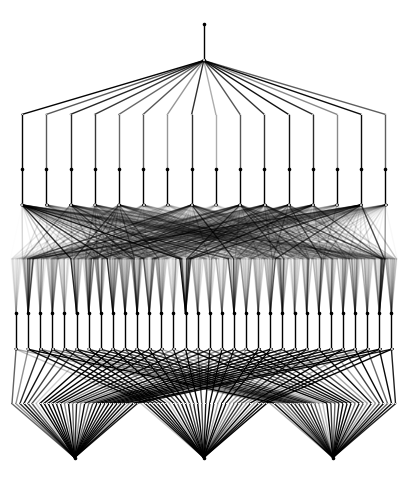

In [8]:
# Train the model with Adam optimizer for KAN model
loss_histories = defaultdict(list)
loss_histories['KAN'] = train_model(kan_model, X_tensor, y_tensor, epochs=500, lr=1e-5)  # Reduced learning rate for stability

# Plot the model at initialization
kan_model.plot()  # Removed redundant plot


### 8. Pruning and Refinement

saving model version 0.1


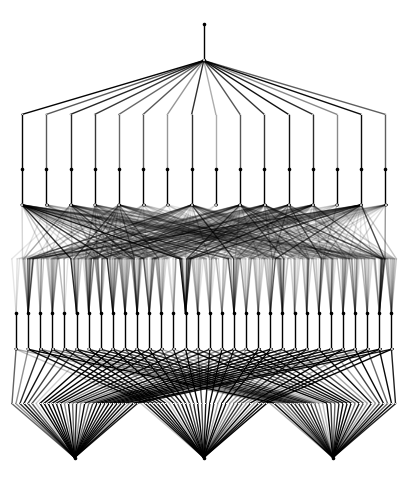

In [9]:
# Prune the model to simplify the structure
kan_model = kan_model.prune()

# Plot pruned model
kan_model.plot()

# Continue training after pruning
loss_histories['KAN'] += train_model(kan_model, X_tensor, y_tensor, epochs=50, lr=1e-5)


### 9. Further Refinement

In [10]:
# Refine the model by splitting nodes
kan_model = kan_model.refine(10)

# Train the model again
loss_histories['KAN'] += train_model(kan_model, X_tensor, y_tensor, epochs=50, lr=1e-5)


saving model version 0.2


### 10. Set Activation Functions to Symbolic

In [11]:
# Retrain KAN to stabilize before symbolic assignment
print("Retraining KAN model to stabilize before symbolic assignment...")
loss_histories['KAN'] += train_model(kan_model, X_tensor, y_tensor, epochs=100, lr=1e-6)  # Further reduced learning rate for stability

# Clamp model outputs to avoid NaN values
with torch.no_grad():
    output_check = kan_model(X_tensor)
    output_check = torch.clamp(output_check, min=-10, max=10)  # Clamp output values to prevent NaNs

mode = "auto"  # "manual" or "auto"

if mode == "manual":
    # Manually set symbolic functions
    kan_model.fix_symbolic(0, 0, 0, 'sin')
    kan_model.fix_symbolic(0, 1, 0, 'x^2')
    kan_model.fix_symbolic(1, 0, 0, 'exp')
elif mode == "auto":
    # Automatically find symbolic functions
    lib = ['x', 'x^2', 'x^3', 'x^4', 'exp', 'log', 'sqrt', 'tanh', 'sin', 'abs']
    kan_model.auto_symbolic(lib=lib)

# Train till convergence with a reduced learning rate for stability
loss_histories['KAN'] += train_model(kan_model, X_tensor, y_tensor, epochs=50, lr=1e-6)


Retraining KAN model to stabilize before symbolic assignment...
Epoch [100/100], Loss: 0.1457
fixing (0,0,0) with sin, r2=0.9960997489335661, c=2
fixing (0,0,1) with sin, r2=0.9939546947758225, c=2
fixing (0,0,2) with sin, r2=0.9997726993136941, c=2
fixing (0,0,3) with sin, r2=0.9963558372734855, c=2
fixing (0,0,4) with x, r2=0.9103493862683987, c=1
fixing (0,0,5) with x, r2=0.9847219193148912, c=1
fixing (0,0,6) with x, r2=0.19356597962520383, c=1
fixing (0,0,7) with sin, r2=0.9998647691255669, c=2
fixing (0,0,8) with log, r2=0.9997794332226919, c=2
fixing (0,0,9) with sin, r2=0.9994867759255613, c=2
fixing (0,0,10) with x, r2=0.9080800829031027, c=1
fixing (0,0,11) with sin, r2=0.9992896648462931, c=2
fixing (0,0,12) with log, r2=0.9978931023328839, c=2
fixing (0,0,13) with sin, r2=0.9940383301944193, c=2
fixing (0,0,14) with sin, r2=0.9990117108039456, c=2
fixing (0,0,15) with x, r2=0.6496334770125023, c=1
fixing (0,0,16) with exp, r2=0.9951729631894015, c=2
fixing (0,0,17) with x, 

### 11. Obtain the Symbolic Formula

Symbolic Expression: -0.0112*x_1 + 0.0038*x_2 + 0.0133*x_3 - 0.0015*sqrt(1 - 0.8743*x_1) - 0.4786*exp(-1.7006*exp(1.5281*x_3) - 1.5927*sin(1.1379*x_2 + 8.5919))/(1 - 0.5099*x_1)**2.9414 - 0.1953*exp(-0.9192*exp(1.5281*x_3) - 0.8609*sin(1.1379*x_2 + 8.5919))/(1 - 0.5099*x_1)**1.5899 + 0.0003*(-x_2 - 0.5318)**2 - 0.0004*(-x_3 - 0.2509)**2 - 0.0002*(-0.9882*x_1 - 0.6925*sin(1.0191*x_3 - 3.7861) + tanh(1.7025*x_2 - 1.1875) - 0.0563)**2 - 0.0013*(-0.0214*x_1 - x_2 - 0.4484*x_3 - 0.0531)**2 - 0.0012*(-0.0214*x_1 - x_2 - 0.4484*x_3 + 0.3733)**2 - 0.0013*(-0.0166*x_1 - 0.7743*x_2 - 0.3472*x_3 - 1)**2 + 0.0001*(-0.0151*x_1 - 0.7026*x_2 - 0.3151*x_3 - 1)**2 + 0.0005*(0.2711*x_1 + 0.6487*(-x_2 - 0.5318)**2 - 0.6964*sin(1.4827*x_3 + 8.6196) + 1)**2 + 0.002*(-0.0494*x_2 - 0.4686*x_3 - sin(1.1411*x_1 - 4.0386) + 0.2393)**2 + 0.005*(0.2434*x_2 - 0.2326*exp(1.6579*x_1) - 0.4271*exp(1.008*x_3) - 1)**2 + 0.0106*(0.4238*x_2 - 0.8388*sqrt(1 - 0.8743*x_1) - 0.2327*(-x_3 - 0.2509)**2 + 1)**2 + 0.0015*(0.499

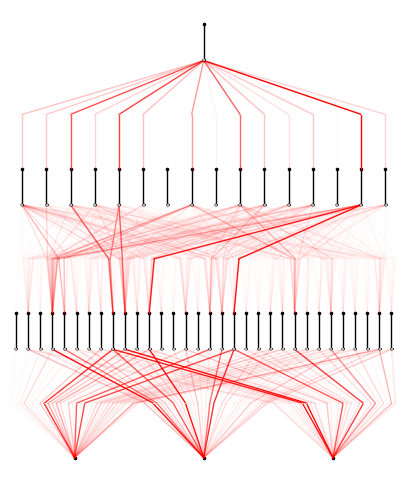

In [12]:
symbolic_expression = ex_round(kan_model.symbolic_formula()[0][0], 4)
print(f"Symbolic Expression: {symbolic_expression}")

# Plot the final model
kan_model.plot()


### 12. Training CNN and MLP Models

In [17]:


print("\nTraining CNN...")
loss_histories['CNN'] = train_model(cnn_model, X_tensor.unsqueeze(0).transpose(1, 2), y_tensor)

print("\nTraining MLP...")
loss_histories['MLP'] = train_model(mlp_model, X_tensor, y_tensor)



Training CNN...


Could not load library libcudnn_cnn_train.so.8. Error: /usr/local/cuda-11.8/lib64/libcudnn_cnn_train.so.8: symbol _ZN5cudnn3cnn5infer22queryClusterPropertiesERPhS3_ version libcudnn_cnn_infer.so.8 not defined in file libcudnn_cnn_infer.so.8 with link time reference
Could not load library libcudnn_cnn_train.so.8. Error: /usr/local/cuda-11.8/lib64/libcudnn_cnn_train.so.8: symbol _ZN5cudnn3cnn5infer22queryClusterPropertiesERPhS3_ version libcudnn_cnn_infer.so.8 not defined in file libcudnn_cnn_infer.so.8 with link time reference
Could not load library libcudnn_cnn_train.so.8. Error: /usr/local/cuda-11.8/lib64/libcudnn_cnn_train.so.8: symbol _ZN5cudnn3cnn5infer22queryClusterPropertiesERPhS3_ version libcudnn_cnn_infer.so.8 not defined in file libcudnn_cnn_infer.so.8 with link time reference
Could not load library libcudnn_cnn_train.so.8. Error: /usr/local/cuda-11.8/lib64/libcudnn_cnn_train.so.8: symbol _ZN5cudnn3cnn5infer22queryClusterPropertiesERPhS3_ version libcudnn_cnn_infer.so.8 not d

RuntimeError: GET was unable to find an engine to execute this computation

In [16]:
device = torch.device('cpu')

### 13. Plot Training Loss Curves


Plotting loss curves...


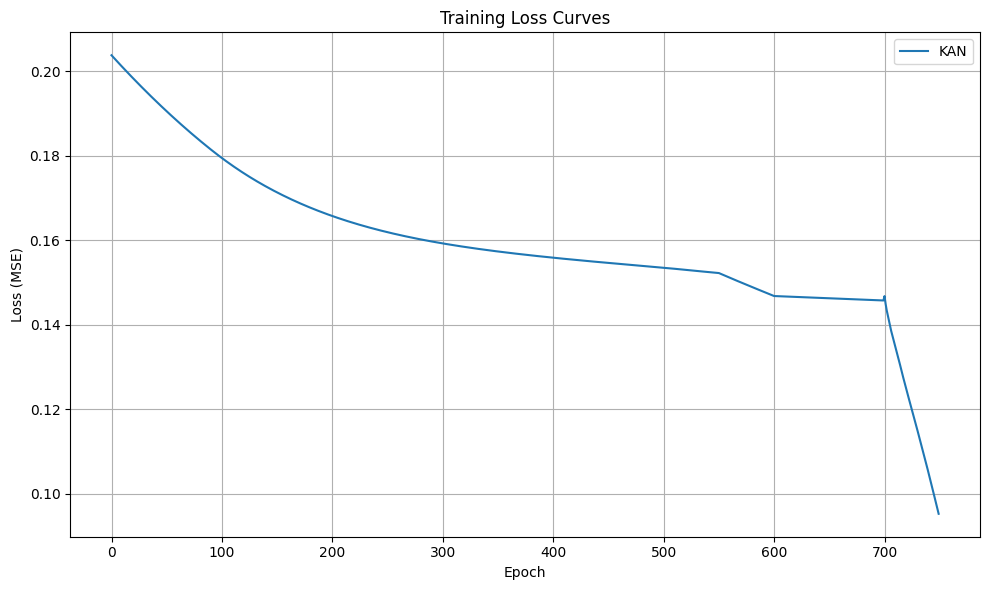

In [18]:
def plot_loss_curves(loss_histories, title="Training Loss Curves"):
    """Plot training loss curves for all models."""
    plt.figure(figsize=(10, 6))
    
    for model_name, loss_history in loss_histories.items():
        plt.plot(loss_history, label=model_name)
    
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

print("\nPlotting loss curves...")
plot_loss_curves(loss_histories)


### 14. Model Comparison Visualization


Plotting prediction results...


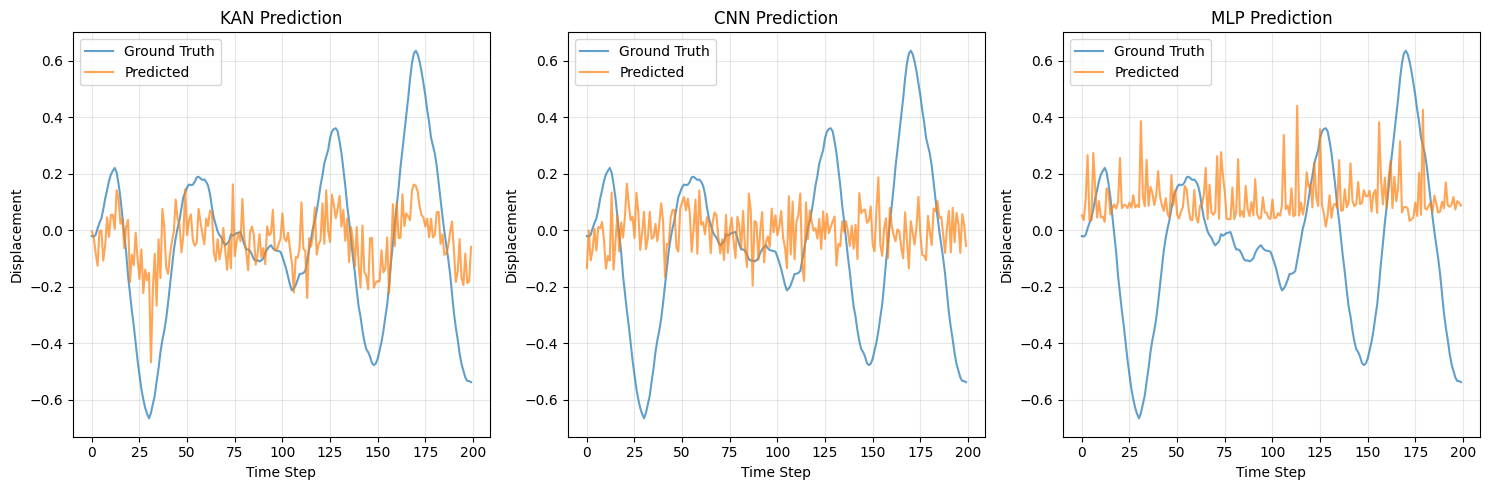

In [19]:
def plot_results(models, X_tensor, X_cnn, y, title_prefix="Model Predictions"):
    """Plot model predictions."""
    plt.figure(figsize=(15, 5))
    
    for i, (name, model) in enumerate(models.items(), 1):
        plt.subplot(1, 3, i)
        model.eval()
        with torch.no_grad():
            if name == 'CNN':
                predictions = model(X_cnn)
                y_pred = predictions.squeeze().cpu().numpy()
            else:  # KAN or MLP
                predictions = model(X_tensor)
                y_pred = predictions.squeeze().cpu().numpy()
            
            # Ensure y_pred is the right shape
            if y_pred.ndim == 0:
                y_pred = np.array([float(y_pred)])
            
            # Plot only first 200 points
            plot_range = slice(0, 200)
            plt.plot(y[plot_range], label='Ground Truth', alpha=0.7)
            plt.plot(y_pred[plot_range], label='Predicted', alpha=0.7)
            plt.title(f'{name} Prediction')
            plt.xlabel('Time Step')
            plt.ylabel('Displacement')
            plt.legend()
            plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

models = {
    'KAN': kan_model,
    'CNN': cnn_model,
    'MLP': mlp_model
}

print("\nPlotting prediction results...")
plot_results(models, X_tensor, X_tensor.unsqueeze(0).transpose(1, 2), y)
